<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/lognormal_univariate_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyro-ppl=='1.8.0'

     |████████████████████████████████| 713 kB 8.4 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from scipy.stats import norm, lognorm, binom

## Simulate fake data

In [15]:
rng = np.random.default_rng(2022)  #see https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
nobs = 125
options = {'size':nobs, 'random_state':rng}
x1 = binom.rvs(1,0.4,  **options) # simulated categorical predictor

beta0 = -10.
beta1 = 5.
sigma = 1.

xb = beta0 + beta1*x1
exb = np.exp(xb)
y = lognorm.rvs(s=sigma, scale=exb, **options)

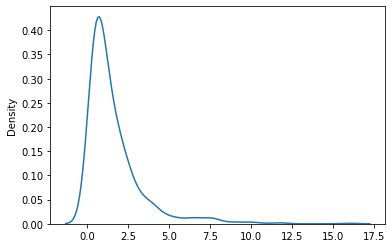

In [24]:
samples = dist.LogNormal(loc=0., scale=1.).sample([800])
sns.kdeplot(data=samples);

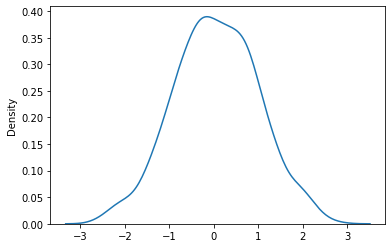

In [25]:
sns.kdeplot(data=samples.log());

## Model


In [43]:
data = tensor(x1, dtype=torch.float).unsqueeze(1) #unsqueeze needed if only one predictor
target = tensor(y, dtype=torch.float)
data.size(), data.dtype, target.size(), target.dtype

(torch.Size([125, 1]), torch.float32, torch.Size([125]), torch.float32)

In [47]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

class BayesianLognormalRegression(PyroModule):
    def __init__(self, *, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        if bias:
          self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))
        self.linear.weight = PyroSample(dist.Normal(0., 5.).expand([out_features, in_features]).to_event(2))

        
    def forward(self, data, target=None):
        mu = self.linear(data).squeeze(-1)
        sigma = pyro.sample("sigma", dist.Exponential(1.))
        with pyro.plate("data", data.shape[0]):
            obs = pyro.sample("obs", dist.LogNormal(loc=mu, scale=sigma), obs=target)
        return mu

In [48]:
data.size(), target.size()

(torch.Size([125, 1]), torch.Size([125]))

In [50]:
model = BayesianLognormalRegression(in_features=1) #out_features is usually one, so one is the default arg

from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data, target)

Sample: 100%|██████████| 1200/1200 [00:19, 61.07it/s, step size=6.10e-01, acc. prob=0.926]


In [51]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
hmc_samples.keys()

dict_keys(['linear.bias', 'linear.weight', 'sigma'])

Warmup:   0%|          | 0/1200 [01:51, ?it/s]


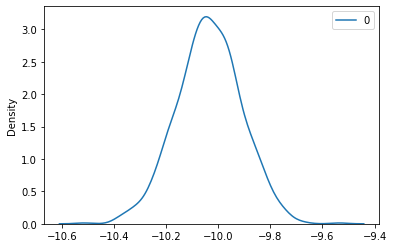

In [52]:
sns.kdeplot(data=hmc_samples['linear.bias']);

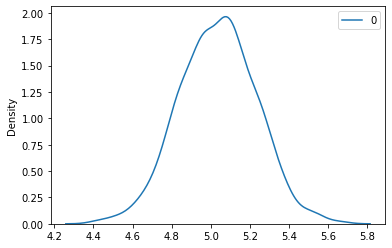

In [53]:
sns.kdeplot(data=hmc_samples['linear.weight'][:,:,0]);

In [59]:
hmc_samples['linear.bias'].mean(), (hmc_samples['linear.weight'][:,:,0]).mean(), hmc_samples['sigma'].mean()

(-10.035906, 5.035659, 1.0161332)

In [60]:
beta0, beta1, sigma

(-10.0, 5.0, 1.0)